<a href="https://colab.research.google.com/github/ArkanEmre/AI-Based-Retail-Product-Identification/blob/master/ai_based_retail_product_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Preprocessing


In [ ]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
import csv
import datetime
import itertools
import json
import os
import tarfile
from shutil import copy, copy2, copyfile
from textwrap import wrap

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from google.colab import drive
from keras_preprocessing.image import ImageDataGenerator
from numpy import argmax
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import (AUC, CategoricalAccuracy,
                                      CategoricalCrossentropy,
                                      MeanAbsolutePercentageError, Precision,
                                      Recall, TruePositives, TrueNegatives, FalsePositives, FalseNegatives)
from tensorflow.keras.callbacks import (EarlyStopping,
                                        TensorBoard,
                                        ModelCheckpoint)
from tensorflow.keras.preprocessing import image
from tensorflow_addons.metrics import F1Score

In [ ]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
tar = tarfile.open("/content/drive/My Drive/Colab Notebooks/datasets/grozi120.tar.gz", "r")
tar.extractall('/content')

In [ ]:
dataset_path = '/content/grozi120'
new_path = '/content/grozi120/processed'
resize_pad = True
IMG_SIZE = 200
BATCH_SIZE = 128

In [ ]:
from PIL import Image, ImageOps

def resize_with_pad(file_path, img_size):
  img = Image.open(file_path)
  old_size = img.size  
  ratio = float(img_size) / max(old_size)
  new_size = tuple([int(x * ratio) for x in old_size])

  img = img.resize(new_size, Image.ANTIALIAS)

  new_img = Image.new("RGB", (img_size, img_size))
  new_img.paste(img, ((img_size - new_size[0]) // 2,
                  (img_size - new_size[1]) // 2))
  return new_img

In [ ]:
if not os.path.exists(os.path.join(new_path, 'inVitro')):
  os.makedirs(os.path.join(new_path, 'inVitro'))

labels = {}
with open(os.path.join(dataset_path, 'UPC_index.txt'), 'r') as f:
  lines = [line.rstrip() for line in f.readlines()[1:] if line != '\n']
  for i in range(0, len(lines)-2, 3):
    labels[int(lines[i])] = [lines[i+1], lines[i+2]]

dataset = {
  'file_name': [], 
  'label': []
}
for product in os.listdir(os.path.join(dataset_path, 'inVitro')):
  for product_file in os.listdir(os.path.join(dataset_path, 'inVitro', product, 'web', 'JPEG')):
    if product_file == 'Thumbs.db':
      continue
    dataset['file_name'].append(os.path.join(dataset_path, 'inVitro', product, 'web', 'JPEG', product_file))
    dataset['label'].append(labels[int(product)][1])

df = pd.DataFrame(dataset, columns=['file_name', 'label'])

In [ ]:
if not os.path.exists(os.path.join(new_path, 'inSitu')):
    os.makedirs(os.path.join(new_path, 'inSitu'))

evaluation_dataset = {
  'file_name': [], 
  'label': []
}

for product in os.listdir(os.path.join(dataset_path, 'inSitu')):
  for product_file in os.listdir(os.path.join(dataset_path, 'inSitu', product, 'video')):
    if product_file == 'Thumbs.db':
      continue
    evaluation_dataset['file_name'].append(os.path.join(dataset_path, 'inSitu', product, 'video', product_file))
    evaluation_dataset['label'].append(labels[int(product)][1])

evaluation_df = pd.DataFrame(evaluation_dataset, columns=['file_name', 'label'])

with open(os.path.join(new_path, 'inSitu', 'evaluation.csv'), mode='w') as dataset_file:
  dataset_writer = csv.writer(dataset_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  dataset_writer.writerow(['file_name', 'label'])
  for file_name, label in zip(evaluation_dataset['file_name'], evaluation_dataset['label']):
    split = file_name.split('/')
    dataset_writer.writerow(['{}_{}'.format(split[-3], split[-1]), label])
    if resize_pad:
      padded_img = resize_with_pad(file_name, IMG_SIZE)
      padded_img.save(os.path.join(new_path, 'inSitu','{}_{}'.format(split[-3], split[-1])))
    else:
      copyfile(file_name, os.path.join(new_path, 'inSitu','{}_{}'.format(split[-3], split[-1])))

In [ ]:
train_filenames, validation_filenames, train_labels, validation_labels = train_test_split(df['file_name'], df['label'], train_size=0.75, random_state=42, stratify=df['label'])

if not os.path.exists(os.path.join(new_path, 'inVitro', 'train')):
    os.makedirs(os.path.join(new_path, 'inVitro', 'train'))
with open(os.path.join(new_path, 'inVitro', 'train.csv'), mode='w') as dataset_file:
    dataset_writer = csv.writer(dataset_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dataset_writer.writerow(['file_name', 'label'])
    for file_name, label in zip(train_filenames, train_labels):
        split = file_name.split('/')
        dataset_writer.writerow(['{}_{}'.format(split[-4], split[-1]), label])
        if resize_pad:
          padded_img = resize_with_pad(file_name, IMG_SIZE)
          padded_img.save(os.path.join(new_path, 'inVitro', 'train','{}_{}'.format(split[-4], split[-1])))
        else:
          copyfile(file_name, os.path.join(new_path, 'inVitro', 'train','{}_{}'.format(split[-4], split[-1])))

if not os.path.exists(os.path.join(new_path, 'inVitro', 'validation')):
    os.makedirs(os.path.join(new_path, 'inVitro', 'validation'))
with open(os.path.join(new_path, 'inVitro', 'validation.csv'), mode='w') as dataset_file:
    dataset_writer = csv.writer(dataset_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dataset_writer.writerow(['file_name', 'label'])
    for file_name, label in zip(validation_filenames, validation_labels):
        split = file_name.split('/')
        dataset_writer.writerow(['{}_{}'.format(split[-4], split[-1]), label])
        if resize_pad:
          padded_img = resize_with_pad(file_name, IMG_SIZE)
          padded_img.save(os.path.join(new_path, 'inVitro', 'validation','{}_{}'.format(split[-4], split[-1])))
        else:
          copyfile(file_name, os.path.join(new_path, 'inVitro', 'validation','{}_{}'.format(split[-4], split[-1])))

In [ ]:
! rm -R grozi120/processed/

## Defining data augmentations

In [ ]:
def training_data(file, path):
  global W_SUM
  global H_SUM
  img = cv2.imread(os.path.join(path, file),cv2.IMREAD_COLOR)
  shape = np.array(img).shape
  W_SUM += shape[0]
  H_SUM += shape[1]
  img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
  X.append(np.array(img))

def invert_image(img):
  return (255-img)

Found 507 validated image filenames belonging to 120 classes.
Found 169 validated image filenames belonging to 120 classes.
Found 11194 validated image filenames belonging to 120 classes.


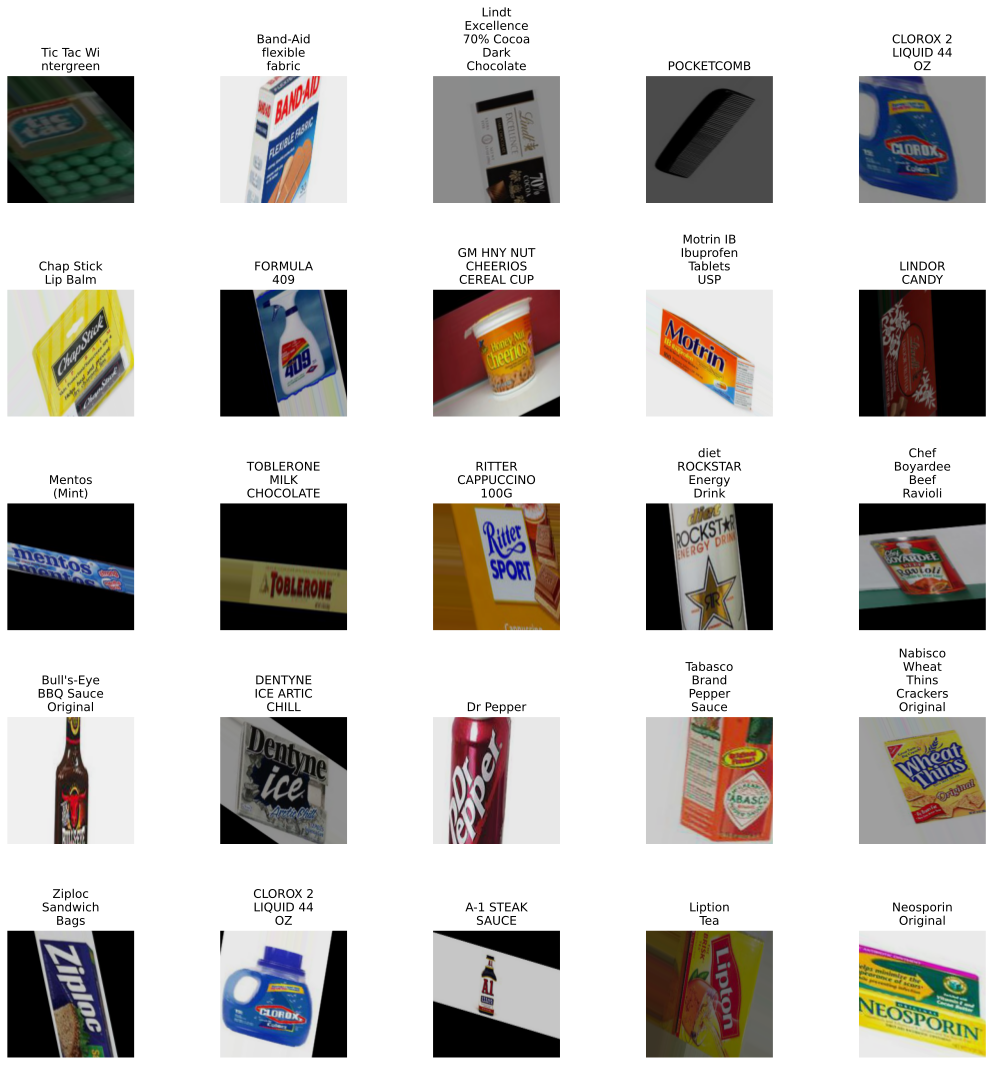

In [ ]:
train_df = pd.read_csv(os.path.join(new_path, 'inVitro', 'train.csv'))
validation_df = pd.read_csv(os.path.join(new_path, 'inVitro', 'validation.csv'))
evaluation_df = pd.read_csv(os.path.join(new_path, 'inSitu', 'evaluation.csv'))

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,  
    featurewise_std_normalization=False, 
    samplewise_center=False,  
    samplewise_std_normalization=False,  
    zca_whitening=False,  
    rotation_range=25,  
    zoom_range = 0.5,
    shear_range = 30,
    width_shift_range=0.15,  
    height_shift_range=0.15,
    brightness_range=[0.25,1],
    horizontal_flip=False,  
    vertical_flip=False,
    rescale=1. / 255)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

evaluation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=os.path.join(new_path, 'inVitro', 'train'),
    x_col="file_name",
    y_col="label",
    class_mode="categorical",
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=os.path.join(new_path, 'inVitro', 'validation'),
    x_col="file_name",
    y_col="label",
    class_mode="categorical",
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE)

evaluation_generator  = evaluation_datagen.flow_from_dataframe(
    dataframe=evaluation_df,
    directory=os.path.join(new_path, 'inSitu'),
    x_col="file_name",
    y_col="label",
    class_mode="categorical",
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE)

class_indices = evaluation_generator.class_indices
class_indices_inverted = {v: k for k, v in class_indices.items()}

x,y = train_generator.next()
train_generator.reset()

fig,ax=plt.subplots(5,5)
fig.set_size_inches(15,15)
num = 0
for i in range(5):
  for j in range (5):
    ax[i,j].imshow(x[num])
    mydict = evaluation_generator.class_indices
    inverted = list(mydict.keys())[list(mydict.values()).index(argmax(y[num]))]
    ax[i,j].set_title("\n".join(wrap(inverted, 10)))
    ax[i,j].axis('off')
    num += 1
  num += 1
        
plt.tight_layout()

In [ ]:
evaluation_generator.class_indices

{'26OZ BLUE WINDEX': 0,
 'A-1 STEAK SAUCE': 1,
 'ARM + HAMMER BAKING SODA': 2,
 'AVIATOR POKER CARDS': 3,
 "Act II Butter Lover's Popcorn": 4,
 'Aleve Caplets': 5,
 'Always thin pantiliners': 6,
 'BEEF JERKY': 7,
 'Band-Aid flexible fabric': 8,
 'Bausch & Lomb Renu All in One Multi Purpose Solution': 9,
 "Ben & Jerry's Ice Cream World's Best Vanilla": 10,
 'Blistex "Silk & Shine" Lip gloss and sunscreen SPF 15': 11,
 "Bull's-Eye BBQ Sauce Original": 12,
 'CAMPBELL CHUNKY CLASSIC CHICKEN NOODLE': 13,
 'CARMEX EZ-ON APPLICATOR': 14,
 'CLOROX 2 LIQUID 44 OZ': 15,
 'CLOROX ULTRA LIQUID REG': 16,
 "Campbell's Tomato Soup - Microwavable bowl": 17,
 'Campbells Cream of Chicken soup': 18,
 'Certs Peppermint': 19,
 'Chap Stick Lip Balm': 20,
 'Cheez-It': 21,
 'Chef Boyardee Beef Ravioli': 22,
 'Chex Mix': 23,
 'Claritin Allergy': 24,
 'Crystal Geyser Water': 25,
 'DENTYNE ICE ARTIC CHILL': 26,
 'David Sunflower Seeds': 27,
 'Diet Coke with Lime': 28,
 'Dove Anti-Perspirant/Deodorant Fresh Invis

In [ ]:
cur_date = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join('content', 'training', cur_date)
model_filename_variables = 'weights.{epoch:02d}-{val_auc_pr:.2f}.hdf5'
model_filename = 'weights.hdf5'
checkpoint_path = os.path.join(log_dir, 'checkpoints', model_filename)

if not os.path.exists(log_dir):
    os.makedirs(log_dir)

if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

callbacks = []
early_stopping = EarlyStopping(
  monitor='val_auc_pr',
  verbose=1, 
  patience=10, 
  mode='max', 
  restore_best_weights=True)

callbacks.append(early_stopping)

tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks.append(tensorboard)
model_checkpoint = ModelCheckpoint(model_filename, 
                                   monitor='val_auc_pr', 
                                   verbose=1, 
                                   save_best_only=True,
                                   save_weights_only=True, 
                                   mode='max', 
                                   save_freq='epoch', 
)
callbacks.append(model_checkpoint)

num_classes = len(train_generator.class_indices)

metrics = [CategoricalAccuracy(name='categorical_accuracy'),
    Precision(name='precision'),
    Recall(name='recall'),
    AUC(name='auc_pr', curve='PR'),
    AUC(name='auc_roc', curve='ROC'),
    F1Score(name='f1score', num_classes=num_classes), 
    TrueNegatives(name='tn'), 
    TruePositives(name='tp'), 
    FalseNegatives(name='fn'), 
    FalsePositives(name='fp')]

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.InceptionResNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet')
                                    
base_model.trainable = False

In [ ]:
regularizer = tf.keras.regularizers.L1L2(l1=0.0001, l2=0.0001)
global_average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()
global_max_pooling_layer = tf.keras.layers.GlobalMaxPooling2D()
max_pooling = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
dropout_layer = tf.keras.layers.Dropout(0.3)
dense = tf.keras.layers.Dense(2048, activation='relu')
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax', activity_regularizer=regularizer)

In [ ]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = global_average_pooling_layer(x)
x = dense(x)
x = dropout_layer(x)
y = prediction_layer(x)

model = tf.keras.Model(inputs, y)

In [ ]:
base_learning_rate = 0.00005
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=metrics)

model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 200, 200, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1536)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 2048)              3147776   
_________________________________________________________________
dropout_7 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 120)               245880    
Total params: 57,730,392
Trainable params: 3,393,656
Non-trainable params: 54,336,736
_________________________________

In [ ]:
num_epochs = 300

history = model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator,  callbacks=callbacks)

Epoch 1/300
4/4 [==============================] - ETA: 0s - loss: 5.2395 - categorical_accuracy: 0.0108 - precision: 0.0092 - recall: 0.1022 - auc_pr: 0.0068 - auc_roc: 0.3497 - f1score: 0.0051 - tn: 82353.0000 - tp: 78.0000 - fn: 685.0000 - fp: 8444.0000
Epoch 00001: val_auc_pr improved from -inf to 0.00999, saving model to weights.hdf5
4/4 [==============================] - 17s 4s/step - loss: 5.2395 - categorical_accuracy: 0.0108 - precision: 0.0092 - recall: 0.1022 - auc_pr: 0.0068 - auc_roc: 0.3497 - f1score: 0.0051 - tn: 82353.0000 - tp: 78.0000 - fn: 685.0000 - fp: 8444.0000 - val_loss: 4.9008 - val_categorical_accuracy: 0.0237 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc_pr: 0.0100 - val_auc_roc: 0.5469 - val_f1score: 0.0119 - val_tn: 20111.0000 - val_tp: 0.0000e+00 - val_fn: 169.0000 - val_fp: 0.0000e+00
Epoch 2/300
4/4 [==============================] - ETA: 0s - loss: 4.9076 - categorical_accuracy: 0.0138 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc_

In [ ]:
! rm weights.*

In [ ]:
cur_date = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join('content', 'training', cur_date)
model_filename = 'fine_tuning_weights.hdf5'
checkpoint_path = os.path.join(log_dir, 'checkpoints', model_filename)

if not os.path.exists(log_dir):
    os.makedirs(log_dir)

callbacks_ft = []
early_stopping_ft = EarlyStopping(
  monitor='val_auc_pr',
  verbose=1, 
  patience=10, 
  mode='max', 
  restore_best_weights=True)

callbacks_ft.append(early_stopping_ft)

tensorboard_ft = TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks_ft.append(tensorboard_ft)
model_checkpoint_ft = ModelCheckpoint(model_filename, 
                                   monitor='val_auc_pr', 
                                   verbose=1, 
                                   save_best_only=True,
                                   save_weights_only=True, 
                                   mode='max', 
                                   save_freq='epoch', 
)
callbacks_ft.append(model_checkpoint_ft)


In [ ]:
base_model.trainable = True

base_learning_rate = 0.000001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=metrics)

model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 200, 200, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1536)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 2048)              3147776   
_________________________________________________________________
dropout_7 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 120)               245880    
Total params: 57,730,392
Trainable params: 57,669,848
Non-trainable params: 60,544
____________________________________

In [ ]:
fine_tune_epochs = 100

total_epochs =  history.epoch[-1] + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_generator, callbacks=callbacks_ft)

Epoch 170/269
4/4 [==============================] - ETA: 0s - loss: 0.5039 - categorical_accuracy: 0.8920 - precision: 0.9712 - recall: 0.7485 - auc_pr: 0.9484 - auc_roc: 0.9968 - f1score: 0.8836 - tn: 80429.0000 - tp: 506.0000 - fn: 170.0000 - fp: 15.0000
Epoch 00170: val_auc_pr improved from 0.92384 to 0.92547, saving model to weights.hdf5
4/4 [==============================] - 17s 4s/step - loss: 0.5039 - categorical_accuracy: 0.8920 - precision: 0.9712 - recall: 0.7485 - auc_pr: 0.9484 - auc_roc: 0.9968 - f1score: 0.8836 - tn: 80429.0000 - tp: 506.0000 - fn: 170.0000 - fp: 15.0000 - val_loss: 0.6282 - val_categorical_accuracy: 0.8580 - val_precision: 0.9618 - val_recall: 0.7456 - val_auc_pr: 0.9255 - val_auc_roc: 0.9926 - val_f1score: 0.7933 - val_tn: 20106.0000 - val_tp: 126.0000 - val_fn: 43.0000 - val_fp: 5.0000
Epoch 171/269
4/4 [==============================] - ETA: 0s - loss: 0.4337 - categorical_accuracy: 0.9093 - precision: 0.9758 - recall: 0.7968 - auc_pr: 0.9670 - auc_r

In [ ]:
import json

hist_df = pd.DataFrame(history.history) 

# save history to json:  
hist_json_file = '/content/history.json'
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [ ]:
import json

hist_ft_df = pd.DataFrame(history_fine.history) 

# save fine-tuning history to json:  
hist_ft_json_file = '/content/history_fine.json'
with open(hist_ft_json_file, mode='w') as f:
    hist_ft_df.to_json(f)

In [ ]:
import datetime

#model_path =  '/content/drive/My Drive/Colab Notebooks/models/grozi120/InceptionResNetV2_imagenet_{}.h5'.format(datetime.datetime.now().strftime("%d_%m_%y_%H_%M_%S"))
#model.save(model_path) 
#model.load_weights('/content/drive/My Drive/Colab Notebooks/models/grozi120/InceptionResNetV2_imagenet_19_06_20_13_35_08.h5')

In [ ]:
evaluation = model.evaluate(evaluation_generator)

evaluation_data_df = pd.DataFrame(evaluation) 

# save evaluation to json:  
evaluation_json_file = '/content/evaluation.json'
with open(evaluation_json_file, mode='w') as f:
    evaluation_data_df.to_json(f)

88/88 [==============================] - 34s 390ms/step - loss: 2.8673 - categorical_accuracy: 0.3820 - precision: 0.5641 - recall: 0.3099 - auc_pr: 0.3814 - auc_roc: 0.8844 - f1score: 0.3414 - tn: 1329405.0000 - tp: 3469.0000 - fn: 7725.0000 - fp: 2681.0000


In [ ]:
f_scores = model.evaluate(evaluation_generator)[6]

88/88 [==============================] - 41s 464ms/step - loss: 3.1253 - categorical_accuracy: 0.3555 - precision: 0.6282 - recall: 0.2676 - auc: 0.8667 - categorical_crossentropy: 5.1972 - f1score: 0.2995


In [100]:
# from https://deeplizard.com/learn/video/km7pxKy4UHU
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues, file_name='confusion_matrix'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.figure(figsize=(64,64))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(os.path.join('/content', file_name) + '.svg')

In [ ]:
def get_image (path):
    img = image.load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
    x = np.array(img).astype('float64')/255
    x = np.expand_dims(x, axis=0)
    return x

In [ ]:
class_numbers_predicted = []
class_numbers_actual = []

labels_ = evaluation_df.groupby("label")
for label in labels_:
  for path in label[1]["file_name"]:
    x = get_image(os.path.join(dataset_path, 'processed', 'inSitu', path))
    p = model.predict(x)
    predicted = class_indices_inverted[argmax(p)]
    class_numbers_predicted.append(argmax(p))
    actual = label[0]
    class_numbers_actual.append(class_indices[actual])

In [101]:
cm = confusion_matrix(y_true=class_numbers_actual, y_pred=class_numbers_predicted)
cm_plot_labels = evaluation_generator.class_indices
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, normalize=False, title='Confusion Matrix GroZi-120', file_name='confusion_matrix_grozi120')

Confusion matrix, without normalization
